In [1]:
# !pip install arviz==0.6.1 -q
# !pip install arviz==0.11.0 -q # new
# !pip install pymc3==3.8 -q
# !pip install Theano==1.0.4 -q

In [1]:
# !pip install arviz==0.11.0 -q 
# !pip install pymc3==3.8 -q
# !pip install Theano==1.0.4 -q

In [3]:
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import IPython
import seaborn as sns
import arviz as az
import csv
import json

print('Running on Python v{}'.format(np.__version__))
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on Python v1.19.2
Running on PyMC3 v3.8
Running on ArviZ v0.6.1


# Define plot functions

In [4]:
#@ def, Plot heatmaps subplots 
def plotHeatmaps(data,
                 rowTitles,
                 colTitles,
                 xLabel,
                 yLabel,
                 nRows,
                 nCols,
                 vmins,
                 vmaxs,
                 iRow):
    
    fig = plt.figure(figsize=[4,12])
    
    # im identifier:
    im = [None]*nCols
    x1, x2 = data[0] # Free parameters of the data.
    f = data[1] # Data that is the function of the free parameters.
    
    # Return the last row that is 'True' in 'plotWhat'. It sets in what row 
    # to show 'xlabel':
    max_plotWhat = np.max(np.where(plotWhat))
    
    # plot the nRows x nCols subplots with labels, titles at  
    # sceciefic locations. iCol is Column index, iRow is Row index:
    for iCol in range(nCols):
        fig.add_subplot(nRows, nCols, iRow*nCols + iCol+1)
        im[iCol] = plt.pcolor(x1 ,x2, f[iCol],
                              vmin=vmins[iCol], vmax=vmaxs[iCol],
                              shading='auto', cmap='Purples')
        
        if True:  # iRow > 0:
            dep_levels = np.arange(25., 250., 25.)
            cs = plt.contour(x1, x2, f[iCol], dep_levels, colors='k',
                             vmin=vmins[iCol], vmax=vmaxs[iCol])
            plt.clabel(cs, dep_levels, inline=True, fmt='%.0f', fontsize=10)
            
        fig.colorbar(im[iCol])
        
        if iRow == 0:
            plt.title(colTitles[iCol] + rowTitles[iRow])
        
        else:
            plt.title(rowTitles[iRow])
        
        if iRow == max_plotWhat:
            plt.xlabel(xLabel)
            
        if iCol == 0:
            plt.ylabel(yLabel)
    
    fig.tight_layout()
    

In [5]:
DataToPlot = 4*[None]
plotWhat = [True,False,False,False]

def plotData(DataToPlot,plotWhat):
    # titles and labels:
    xLabel = "t(sec)"
    yLabel = "$\kappa(kTnm^2)$"

    dep_Title = "$Depletion$\n"
    colTitles = [dep_Title]
    
    
    rowTitles = ["Training data","Data fit","Trained parameters","Surrogate"]

    # min and max values for the different heatmaps:
    vmins = [0]
    vmaxs = [250]

    nRows = 4
    nCols = 1
    
    # Plot a row of subplot if the data is not empty and if value is 'True':
    for iRow in range(nRows):
        if DataToPlot[iRow] != None and plotWhat[iRow]:
            plotHeatmaps(data = DataToPlot[iRow],
                         nRows = nRows,
                         nCols = nCols,
                         rowTitles = rowTitles,
                         colTitles = colTitles,
                         xLabel = xLabel,
                         yLabel = yLabel,
                         vmins = vmins,
                         vmaxs = vmaxs,
                         iRow = iRow)


# 2.1. Training data

In [6]:
#@title 2.1.1. Read data
# Training data for model1
# Reading the data files for wTCR, wCD45 and dep:
g11_data_array0 = np.array([[17.661,19.183,19.73,19.805,19.458,19.891,19.527,19.54,19.832,20.157,20.128],
[19.807,20.516,20.608,21.018,20.983,20.983,20.846,20.773,20.84,20.802,20.817],
[14.854,16.5,16.518,16.88,15.239,17.3,18.122,18.695,18.583,18.248,18.701],
[17.808,20.029,19.971,19.622,19.793,19.91,19.881,19.915,19.98,20.045,19.794],
[17.145,16.825,17.533,18.228,19.001,18.377,17.976,18.51,18.094,18.188,18.366],
[19.667,20.514,20.274,20.947,20.916,21.256,21.668,21.175,20.76,20.632,20.101],
[18.68,18.576,18.716,19.04,19.282,19.41,19.602,19.408,19.639,19.461,19.855],
[16.496,18.266,18.58,18.612,18.559,19.555,19.953,20.253,20.713,20.557,20.536],
[17.674,18.396,18.03,18.118,17.606,17.807,18.07,17.928,17.594,17.25,17.308],
[19.08,19.262,18.823,18.762,17.688,16.945,17.339,18.742,18.945,19.308,19.242],
[15.556,17.646,16.964,16.932,17.065,16.846,17.816,16.883,17.014,17.24,17.83],
[18.485,19.306,19.624,19.605,19.746,19.579,20.574,20.42,20.268,20.555,20.235],
[15.822,18.493,18.293,18.172,17.955,17.996,18.483,19.479,19.548,19.265,19.335],
[18.794,19.639,19.373,19.302,18.612,19.361,19.757,19.137,19.559,17.867,18.11],
[19.544,19.512,19.452,19.359,19.638,19.804,19.639,19.734,19.606,19.516,19.298],
[18.865,18.723,18.375,17.985,19.549,19.418,19.875,18.889,18.312,18.905,19.247],
[17.74,19.186,19.218,19.565,19.492,19.574,19.547,19.58,19.534,19.937,20.119],
[18.161,18.791,18.908,19.036,19.124,19.352,19.251,19.114,18.099,17.437,17.8],
[17.938,19.659,19.598,19.619,19.361,19.318,18.931,18.962,18.84,18.572,18.795],
[19.298,20.702,20.232,18.734,18.933,18.68,20.009,20.906,19.983,21.698,21.396]])

g22_data_array0 = np.array([[40.041,52.171,51.35,29.385,29.899,26.539,24.747,25.122,25.862,24.263,23.395],
[40.704,65.18,16.491,21.928,17.19,19.452,19.197,17.847,19.484,21.011,21.138],
[39.042,42.095,16.474,16.675,14.722,13.55,17.955,18.605,18.349,18.939,19.479],
[38.419,47.203,14.739,12.982,12.733,15.255,13.751,16.323,17.894,17.449,19.414],
[39.108,53.466,12.586,12,12.753,14.967,15.872,15.312,17.068,16.613,14.618],
[38.113,45.535,20.098,12.111,11.407,13.368,13.442,13.216,13.973,17.431,15.352],
[39.648,50.23,19.223,12.787,13.078,15.23,13.828,13.692,12.99,12.969,13.974],
[38.017,50.687,17.7,12.634,15.672,13.763,14.569,13.574,15.226,13.608,14.524],
[36.345,69.927,19.105,11.132,11.422,11.372,12.303,11.948,12.753,14.639,14.842],
[40.794,61.187,28.937,13.248,13.526,12.374,12.695,13.368,13.863,11.607,14.586],
[40.921,55.434,15.722,12.631,11.345,11.369,12.609,12.635,12.586,13.711,12.415],
[38.929,56.889,18.765,11.926,11.054,12.053,11.273,11.119,12.761,13.477,13.677],
[39.473,50.729,21.278,12.516,12.972,12.526,12.54,11.717,11.926,13.661,12.903],
[38.131,35.466,11.213,9.67,11.095,10.651,10.628,10.119,12.048,11.376,12.653],
[39.627,53.418,21.563,9.6493,11.463,10.294,10.446,11.087,11.837,11.89,12.081],
[38.691,56.514,13.84,10.841,10.191,10.97,10.824,11.493,11.993,10.927,12.072],
[38.369,63.582,19.472,12.247,12.861,10.001,11.511,11.678,10.888,11.904,10.845],
[38.179,68.412,17.91,11.824,12.56,13.241,10.941,10.486,10.073,10.858,10.58],
[37.695,58.418,21.777,21.935,11.346,10.919,11.021,12.221,11.51,10.89,11.082],
[39.867,56.521,29.038,14.488,12.373,10.574,11.135,10.364,9.2701,10.909,10.99]])

g12_data_array0 = np.array([[21.443,2.146,1.8681,3.8138,3.9293,5.6677,5.3346,4.3738,4.2115,5.28,8.2552],
[24.357,5.1339,6.7392,8.223,9.3518,10.359,11.295,10.972,12.868,13.388,13.722],
[20.173,5.2959,7.333,7.8585,10.086,11.09,11.441,12.287,12.422,13.599,14.602],
[21.048,6.5607,8.4275,10.31,11.318,12.677,13.688,14.361,14.064,14.734,15.726],
[25.645,5.9201,9.4306,10.969,12.123,12.807,13.398,14.336,14.965,15.327,16.625],
[21.139,7.0034,9.7752,10.405,11.668,12.448,13.244,15.181,15.767,16.214,18.283],
[21.274,6.9867,9.6211,11.519,13.453,14.475,15.672,17.101,17.715,18.632,19.162],
[23.961,8.0956,10.543,11.696,13.353,14.386,15.99,17.091,18.055,18.893,19.542],
[22.423,8.268,10.87,11.669,13.451,15.054,16.721,17.912,18.917,19.362,19.769],
[27.017,7.3613,10.131,12.155,13.812,15.167,16.219,16.971,18.294,18.95,19.332],
[20.636,8.0815,10.922,12.998,14.427,15.393,16.38,17.264,17.915,19.277,20.381],
[19.696,9.7434,12.274,13.932,15.715,17.327,18.2,19.712,20.157,21.347,22.44],
[22.62,8.7923,11.49,12.903,14.329,15.736,16.811,17.696,18.532,19.141,20.687],
[21.159,8.8581,10.963,13.294,14.779,16.134,17.312,18.822,19.915,21.127,22.049],
[23.141,7.6794,10.896,12.606,14.96,16.412,17.242,17.534,19.21,20.28,20.491],
[24.11,7.9982,10.606,11.875,13.188,14.998,16.305,17.323,18.873,20.375,20.659],
[25.384,7.243,10.881,13.414,15.346,16.97,18.282,18.986,20.141,21.525,22.371],
[21.893,8.3062,11.252,12.743,14.472,16.041,17.768,19.057,20.07,20.825,21.393],
[23.24,7.2108,10.11,12.491,14.012,16.15,17.421,18.109,19.321,20.581,22.27],
[23.722,9.4973,11.47,13.331,15.163,17.049,17.551,18.817,20.326,20.695,22.219]])

# scaling data to nanometer and cropping data:
# PROGRAMMING RULE #1 - NEVER EVER USE MAGIC NUMBERS
NM_PER_PIXEL = 10

wTCR_array0_nm = 2*NM_PER_PIXEL*g11_data_array0 # x2 because the computation was over half-width
wCD45_array0_nm = 2*NM_PER_PIXEL*g22_data_array0 # x2 because the computation was over half-width
dep_array0_nm = NM_PER_PIXEL*g12_data_array0

size_k, size_t = np.shape(dep_array0_nm)

t0 = np.linspace(0, 100, size_t) # x-axis for arrays (time in seconds)
k0 = np.linspace(100/size_k, 100, size_k) # y-axis for arrays (rigidity in kT*nm^2)


In [7]:
#@title Crop and save training data

# select start indices for t and k:
t_start = 1
k_start = 1

selected_t_inds = np.arange(t_start,size_t,1)
selected_k_inds = np.arange(k_start,size_k,2) # every second value

dep_array1_nm = dep_array0_nm[selected_k_inds,:]
dep_array_nm = dep_array1_nm[:,selected_t_inds]

t = t0[selected_t_inds]
k = k0[selected_k_inds]

[t_array, k_array] = np.meshgrid(t,k)

if True:
    np.save("dep_evidence_nm.npy", dep_array_nm)


In [8]:
#@title 2.1.2. Training data to dataFrame
df_trainingData_model1 = pd.DataFrame(np.array([t_array.flatten(), 
                k_array.flatten(),
                dep_array_nm.flatten()]).T,
                columns=['time_sec', 'k0_kTnm2', 'dep_nm'])

df_trainingData_model1.to_csv('trainingData_model1.csv')

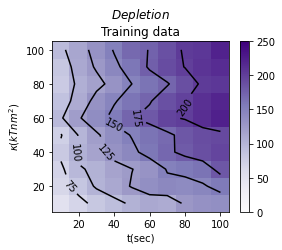

In [9]:

df_dep_nm = df_trainingData_model1.pivot('k0_kTnm2', 'time_sec', 'dep_nm')

t = df_dep_nm.columns
k = df_dep_nm.index

dep_nm = df_dep_nm.values

DataToPlot[0] = [[t,k],[dep_nm]]
plotWhat=[True,False,False,False]

plotData(DataToPlot, plotWhat)


# 2.2. Data fit

In [10]:
#@title 2.2.1 Defined fit fnctions
# fl is for 'flatten'

def linear_z(xy, b, ax, ay):
    x,y = xy
    f = b + ax*x + ay*y
    strf = "b + ax*x + ay*y"
    return f

# def sig(x, min, max, center, devisor):

#     f = min + (max - min)/(1 + np.exp(-(x - center)/devisor))
#     return f

In [11]:
#@title Read training data from csv file
# Reading data from csv file:
df_trainingData_model1 = pd.read_csv('trainingData_model1.csv')


# Reading data from DataFrame:
# 'f' is for 'flatten'  
ft = df_trainingData_model1['time_sec']
fk = df_trainingData_model1['k0_kTnm2']
fdep_nm = df_trainingData_model1['dep_nm']

In [12]:
#@title 2.2.2. Get fit parameters
def get_fit_parameters(X,fitFunc,fXdata,parametersNames,p0):
    """
    Returns fit parameters and aranges them in DataFrames where the index (rows)
    are the fit parameters' names and the columns are 'mu' and 'sd'.
    """
    popt, pcov = curve_fit(fitFunc, X, fXdata, p0)
    mu = popt
    sd = np.sqrt(np.diag(pcov))

    data = {'mu':mu,'sd':sd}
    index = parametersNames
    
    df = pd.DataFrame(data,index=index)

    return df


In [13]:
#@title Fit parameters for dep
p0_dep = 50., 1., 1.
parametersNames_dep = ['intercept', 'tSlope', 'kSlope']
equation_dep = parametersNames_dep[0] + \
                "+" + \
                parametersNames_dep[1] + \
                "*" + \
                "t" + \
                "+" + \
                parametersNames_dep[2] +\
                "*" + \
                "k"

df_fitParameters_dep = get_fit_parameters(X=(ft,fk),
                              fitFunc=linear_z,
                              fXdata=fdep_nm,
                              parametersNames=parametersNames_dep,
                              p0=p0_dep)

df_fitParameters_dep = df_fitParameters_dep.round(3)
display(df_fitParameters_dep)
print(equation_dep)

,mu,sd
intercept,43.137,3.940
tSlope,1.249,0.048
kSlope,0.629,0.048


intercept+tSlope*t+kSlope*k


In [14]:
#@title 2.2.3. Plotting training data vs. data fit
# dep:
dep_fit = df_fitParameters_dep.loc['intercept','mu'] + \
          df_fitParameters_dep.loc['tSlope','mu']*t_array + \
          df_fitParameters_dep.loc['kSlope','mu']*k_array

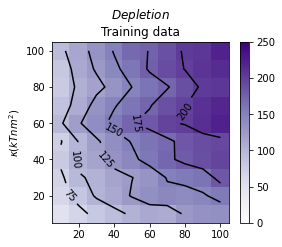

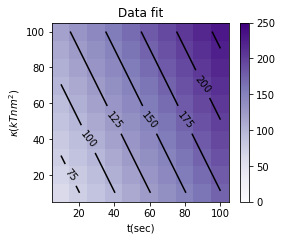

In [15]:
DataToPlot[1] = [[t,k],[dep_fit]]
plotWhat=[True,True,False,False]

plotData(DataToPlot, plotWhat)

# 2.3. Data structure

In [16]:
#@title Class RV new
class RV: # TODO for Barak - make CSV field names correspond to dictionary names or have a meta-dict for it
    def __init__(self,
                 id : str,
                 type2 : str,
                 shortName : str,
                 texName : str,
                 description : str,
                 distribution : str,
                 distributionParameters : dict,
                 units : str):
        
        self.id = id # str
        self.type2 = type2 # str
        self.shortName = shortName # str
        self.texName = texName # str
        self.description = description # str
        self.distribution = distribution # str
        self.distributionParameters = distributionParameters # array
        self.units = units # str


    def get_as_dictionary(self):  
        return {'ID': self.id, # Unique variable name that is used by pymc3, e.g. rv_tSlope_wTCR_KSEG1.
                'Type': self.type2, # Type of variable, e.g. 'Free parameter', 'Random variable'
                'Short Name': self.shortName, # Short name, e.g. 't'.
                'Latex Name': self.texName, # LaTex name for display.
                'Description': self.description, # 
                'Distribution': self.distribution,
                'Distribution parameters': self.distributionParameters,
                'Units': self.units}   

    def get_pymc3_statement():
        '''
        TASK 1
        TODO make this return a 2-tuple from a variable name 
        to a pymc3 statment for creating this random variable
        (to be used as input for eval)
        '''
#         if RV.distribution == "Normal":
#             mu = RV.distributionParameters["mu"]
#             sd = RV.distributionParameters["sd"]
#             s0 = RV.id
#             if RV.shortName == "output":
#                 print(RV.shortName)
#             s1 = ("pm." + RV.distribution + "('" + RV.id  + "'" + \
#                                       ", mu=" + str(mu) + \
#                                       ", sd=" + str(sd) + ")")
#             s = (s0,s1)
#             print(eval("s[0]"),"=",eval("s[1]"))
        '''
        Example: return tuple :
        s = ('rv_alpha', 'pm.Normal("rv_alpha", mu=354, sigma=a*10+b*20)')
        so we can do eval(s[0]) = eval(s[1])
        '''
      # TODO: WRITE-ME
#       return

    @staticmethod
    def RV_from_dictionary(d : dict):
        ''' generates an RV object from a dictionary produced by get_as_dictionary() '''  
        return RV(id=d['ID'],
                type2=d['Type'],
                shortName=d['Short Name'],
                texName=d['Latex Name'],
                description=d['Description'],
                distribution=d['Distribution'],
                distributionParameters=d['Distribution parameters'],
                units=d['Units'])


In [17]:
#@title Class model
model1_description = """Distributions and inter distances of TCR and CD45 molecules
that result from the early contact of a T cell and APC (Antigen Presenting Cell)."""

class Model:
    # Constructor
    def __init__(self, 
                 shortName : str, 
                 longName : str, 
                 description : str, 
                 model_id  : str,
                 RV_csv_file = None, # Topology of Bayes net
                 data_csv_file = None): # Training data
        '''
        '''
        self.shortName = shortName # str
        self.longName = longName # str
        self.description = description # str
        self.model_id = model_id # str
        self.set_RVs_from_csv(RV_csv_file) # fill in random variables from CSV file
        self.set_data_from_csv(data_csv_file) # fill in training data from CSV file

    # add a random variable to the model
    def add_rv(self, rv): # BARAK
        self.RVs.append(rv)

    def get_dataframe(self): # TODO: think about the name
        info = [ rv.get_as_dictionary() for rv in self.RVs ]
        df = pd.DataFrame(info)
        df.set_index('ID', drop=False)  
        return df

    def to_csv(self, csv_file): # TODO: think about the name
        df = self.get_dataframe()
        df.to_csv(csv_file)

    def set_RVs_from_csv(self, csv_file):
        ''' 
        read csv file (similar to Table S1 in metamodeling paper) with random variables
        and set this model's random variables and the statistical relations among them
        accordingly

        If csv_file is None, set an empty list of RVs
        '''
        self.RVs = []
        if csv_file == None:
            return
        df = pd.read_csv(csv_file)
        # TODO: assert that it has all the right fields
        rv_dicts = df.to_dict('records') # TODO: check if this is still appropraite
        print("RV dicts from csv:")
        print(rv_dicts)
        for rv_dict in rv_dicts:
            rv= RV.from_dictionary(rv_dict)
            self.add_rv(rv)

    def set_data_from_csv(self, data_csv_file):
    # TASK 2
        # df = pd.read_csv(data_csv_file)
        # display(df) # Yair
        # TODO: code for filling in table of data
        # self.data = ... # WRITE-ME
        self.trainingData = pd.read_csv(data_csv_file)

    # generate a pymc3 model from this model
    def get_as_pymc3(self): # BARAK
    # TASK 3 - make sure this works
        '''
        Go over all random variables in this model, 
        and generate a PyMC3 object with cooresponding
        variable names and statistical relations among them
        '''
        # TODO (use "eval" command)
        pm_model = pm.Model()
        with pm_model as pm:
             for rv in self.RVs:
                 pass
            #    s = rv.get_pymc3_statement()
            #    eval(s[0]) = eval(s[1])
        return pm_model

    def update_rvs_from_pymc3(self, pymc3): # BARAK
    # TASK 4 
        # TODO: use trace from trained PyMC3 model to update statements for all RVs
        return

    
     

In [18]:
#@title Start model1_dep
model1_dep = Model(shortName = 'KSEG',  # str
               longName = 'Kinetic segregation', # str
               description = 'Model1 description', # str
               model_id = '1', #, # str
               RV_csv_file = None,
               data_csv_file = 'trainingData_model1.csv') 


In [19]:
#@title Define dep untrained table

model1_dep.add_rv(
    RV(id = 'fp_t_dep_KSEG1',
       type2 = 'Free parameter',
       shortName = 't',
       texName = "$$t^{KSEG}$$",
       description = 'Time',
       distribution = 'Uniform',
       distributionParameters = {'lower' : str(0.), 'upper' : str(100.)},
       units = '$$sec$$'))

model1_dep.add_rv(
    RV(id = 'fp_k_dep_KSEG1',
        type2 = 'Free parameter',
        shortName = 'k',
        texName = '$$\kappa^{KSEG}$$',
        description = 'Membrane rigidity',
        distribution = 'Uniform',
        distributionParameters = {'lower' : str(0.), 'upper' : str(100.)},
        units = '$$kTnm^2$$'))

model1_dep.add_rv(
    RV(id = 'rv_intercept_dep_KSEG1',
        type2 = 'Random variable',
        shortName = 'intercept',
        texName = '$$dep^{KSEG}_{intercepct}$$',
        description = 'Depletion range between TCR and CD45',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(df_fitParameters_dep.loc['intercept','mu']), # TODO: get from table 
                                  'sd' : str(df_fitParameters_dep.loc['intercept','sd'])},
        units = '$$nm$$')) 

model1_dep.add_rv(
    RV(id = 'rv_tSlope_dep_KSEG1',
        type2 = 'Random variable',
        shortName = 'tSlope',
        texName = '$$dep^{KSEG}_{tSlope}$$',
        description = 'Plain slope for t',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(df_fitParameters_dep.loc['tSlope','mu']), # TODO: get from table 
                                  'sd' : str(df_fitParameters_dep.loc['tSlope','sd'])},
        units = '$$-$$')) 

model1_dep.add_rv(
    RV(id = 'rv_kSlope_dep_KSEG1',
        type2 = 'Random variable',
        shortName = 'kSlope',
        texName = '$$dep^{KSEG}_{kSlope}$$',
        description = 'Plain slope for k',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(df_fitParameters_dep.loc['kSlope','mu']), # TODO: get from table 
                                  'sd' : str(df_fitParameters_dep.loc['kSlope','sd'])},
        units = '$$-$$'))

model1_dep.add_rv(
    RV(id = 'rv_output_dep_KSEG1',
       type2 = 'Random variable',
       shortName = 'output',
       texName = '$$dep^{KSEG}_{output}$$',
       description = 'dep output',
       distribution = 'Normal',
       distributionParameters = {'mu' : equation_dep, 'sd' : str(20.)},
       units = "$$nm$$")) 

model1_dep.to_csv("Model1_dep.csv")

In [20]:
#@title Display RVs tables as DataFrames
# Display untrained table:
df_model1_untrainedTable = model1_dep.get_dataframe()
df_model1_untrainedTable = df_model1_untrainedTable.set_index('ID')
# display(df_model1_dep_untrainedTable)

display(df_model1_untrainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(200, 150, 255, 0.65)',
                                                'border' : '1px black solid'}))

# Math(r"e^\alpha")

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_t_dep_KSEG1,Free parameter,t,$$t^{KSEG}$$,Time,Uniform,"{'lower': '0.0', 'upper': '100.0'}",$$sec$$
fp_k_dep_KSEG1,Free parameter,k,$$\kappa^{KSEG}$$,Membrane rigidity,Uniform,"{'lower': '0.0', 'upper': '100.0'}",$$kTnm^2$$
rv_intercept_dep_KSEG1,Random variable,intercept,$$dep^{KSEG}_{intercepct}$$,Depletion range between TCR and CD45,Normal,"{'mu': '43.137', 'sd': '3.94'}",$$nm$$
rv_tSlope_dep_KSEG1,Random variable,tSlope,$$dep^{KSEG}_{tSlope}$$,Plain slope for t,Normal,"{'mu': '1.249', 'sd': '0.048'}",$$-$$
rv_kSlope_dep_KSEG1,Random variable,kSlope,$$dep^{KSEG}_{kSlope}$$,Plain slope for k,Normal,"{'mu': '0.629', 'sd': '0.048'}",$$-$$
rv_output_dep_KSEG1,Random variable,output,$$dep^{KSEG}_{output}$$,dep output,Normal,"{'mu': 'intercept+tSlope*t+kSlope*k', 'sd': '20.0'}",$$nm$$


# Untrained model

In [21]:
#@title Untrained model
def get_pm_model1_untrained(df_trainingData_model1):  # model1
    
    pm_model1 = pm.Model()
    with pm_model1:
        dfRV = df_model1_untrainedTable
        DP = 'Distribution parameters'
        ### model1 - KS (kinetic segregation) #######################        
        # from class ################################################
        # model1.D:
        t_KSEG1_obs = df_trainingData_model1.loc[:,'time_sec'].values
        k_KSEG1_obs = df_trainingData_model1.loc[:,'k0_kTnm2'].values

        dep_KSEG1_obs = df_trainingData_model1.loc[:,'dep_nm'].values
        
        # rv_t
        ID = 'fp_t_dep_KSEG1'
        rv_t = pm.Uniform('rv_t',
            lower = dfRV.loc[ID,DP]['lower'],
            upper = dfRV.loc[ID,DP]['upper'],
            observed = t_KSEG1_obs)
        
        # rv_k
        ID = 'fp_k_dep_KSEG1'
        rv_k = pm.Uniform('rv_k',
            lower = dfRV.loc[ID,DP]['lower'],
            upper = dfRV.loc[ID,DP]['upper'],
            observed = k_KSEG1_obs) # todo values
        
        # dep_KSEG ####################################################
        """TODO: read parameters values from RV table"""
        # rv_intercept_dep_KSEG1
        ID = 'rv_intercept_dep_KSEG1'
        rv_intercept_dep_KSEG1 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))
        
        # rv_tSlope_dep_KSEG1
        ID = 'rv_tSlope_dep_KSEG1'
        rv_tSlope_dep_KSEG1 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 
        
        # rv_kSlope_dep_KSEG1
        ID = 'rv_kSlope_dep_KSEG1'
        rv_kSlope_dep_KSEG1 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 
        
        ID = 'rv_output_dep_KSEG1'
        rv_output_dep_KSEG1 = pm.Normal(ID, 
            mu = rv_intercept_dep_KSEG1 +\
            rv_tSlope_dep_KSEG1*rv_t +\
            rv_kSlope_dep_KSEG1*rv_k,
            sd = eval(dfRV.loc[ID,DP]['sd']),
            observed = dep_KSEG1_obs) #
        #############################################################
    return pm_model1



In [23]:
# pm_model1 = get_pm_model1_untrained(df_trainingData_model1) 
gv1 = pm.model_to_graphviz(pm_model1)
gv1   

NameError: name 'pm_model1' is not defined

In [ ]:
# Run untrained model:
with pm_model1:
    trace1 = pm.sample(2000, chains=4);

In [ ]:
pm.traceplot(trace1);

In [ ]:
# save trace_summary:
trace1_summary = pm.summary(trace1).round(3) # var_names=["mu", "tau"]
trace1_summary.to_pickle('trace1_summary')

if False: #False:  
    files.download("trace1_summary") 
# !ls

In [ ]:
#@title Read 'mean' and 'sd' values from 'trace_summary'
# r = read, to distinguish between the original and the saved files.
trace1_summary_r = pd.read_pickle('trace1_summary') 

# displaying the rv names and the data of intersest: 'mean' and 'sd':
mean_sd_r = trace1_summary_r.loc[:, ['mean','sd']]
mean_sd_r

In [ ]:
#@ Update trained parameters values
df_model1_trainedTable = df_model1_untrainedTable
DP = 'Distribution parameters'
for rv in mean_sd_r.index:
#     print(rv)
    df_model1_trainedTable.loc[rv,DP]['mu'] = str(mean_sd_r.loc[rv]['mean'])
    df_model1_trainedTable.loc[rv,DP]['sd'] = str(mean_sd_r.loc[rv]['sd'])
    
df_model1_trainedTable.to_pickle('df_model1_trainedTable') 

In [ ]:
display(df_model1_trainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(200, 150, 255, 0.40)',
                                                'border' : '1px black solid'}))

# df_model1_trainedTable.style.set_table_styles([{'selector' : '',
#                             'props' : [('border','4px solid green')]}])

In [ ]:
#@title Get trained model values
DP = 'Distribution parameters'
# dep:
dep_trained = eval(df_model1_trainedTable.loc['rv_intercept_dep_KSEG1',DP]['mu']) +\
              eval(df_model1_trainedTable.loc['rv_tSlope_dep_KSEG1',DP]['mu'])*t_array +\
              eval(df_model1_trainedTable.loc['rv_kSlope_dep_KSEG1',DP]['mu'])*k_array

In [ ]:
DataToPlot[2] = [[t,k],[dep_trained]]
plotWhat=[True,True,True,False]

plotData(DataToPlot, plotWhat)

In [ ]:
#@title Build trained model (with updated parameter estimates through their posteriors)
def get_pm_model1_trained(df_model1_trainedTable, 
                          observed_t = None, 
                          observed_k = None):
    
    ''' return model1 trained based on trace1. 
    If observed_t and/or observed_k are specified, 
    return the model conditioned on those values '''
    
    pm_model1_trained = pm.Model()
    with pm_model1_trained:
        dfRV = df_model1_trainedTable
        DP = 'Distribution parameters'
        ### model1 - KS (kinetic segregation) ###########################    
        #  #####################################################
        
        rv_t = pm.Normal('rv_t', mu=70, sd=30, observed= observed_t)
        rv_k = pm.Normal('rv_k', mu=50, sd=20, observed= observed_k)

        # dep_KSEG ####################################################
        """TODO: read parameters values from RV table"""
        # rv_intercept_dep_KSEG1
        ID = 'rv_intercept_dep_KSEG1'
        rv_intercept_dep_KSEG1 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))
        
        # rv_tSlope_dep_KSEG1
        ID = 'rv_tSlope_dep_KSEG1'
        rv_tSlope_dep_KSEG1 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 
        
        # rv_kSlope_dep_KSEG1
        ID = 'rv_kSlope_dep_KSEG1'
        rv_kSlope_dep_KSEG1 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 
        
        # rv_output_dep_KSEG1, equation:
        """
        eq = b + a1*x1 + a2*x2
        b = rv_intercept_dep_KSEG1
        a1 = rv_tSlope_dep_KSEG1
        x1 = rv_t
        a2 = rv_kSlope_dep_KSEG1
        x2 = rv_k
        """
        ID = 'rv_output_dep_KSEG1'
        rv_output_dep_KSEG1 = pm.Normal(ID, 
            mu = rv_intercept_dep_KSEG1 +\
            rv_tSlope_dep_KSEG1*rv_t +\
            rv_kSlope_dep_KSEG1*rv_k,
            sd = eval(dfRV.loc[ID,DP]['sd'])) #

    return pm_model1_trained

pm_model1_trained= get_pm_model1_trained(df_model1_trainedTable)
gv1 = pm.model_to_graphviz(pm_model1_trained)
display(gv1)

In [ ]:
if True:
    n_t = 21 # 20 
    n_k = 20 # 20 
    Ts = np.linspace(0,100, n_t)
    Ks = np.linspace(100/n_k,100, n_k)
    
    deps_mean = np.zeros((n_k, n_t))
    deps_std = np.zeros((n_k, n_t))

    for i,k in enumerate(Ks):
        for j,t in enumerate(Ts):
            cur_model= get_pm_model1_trained(df_model1_trainedTable, observed_k= k, observed_t= t)
            with cur_model:
                cur_trace = pm.sample(2000, chains=4, progressbar = False);
            print(f"i,t={i,t}, j,k={j,k}")
    
            deps_mean[i,j] = cur_trace.rv_output_dep_KSEG1.mean() 
            deps_std[i,j] = cur_trace.rv_output_dep_KSEG1.std();

In [ ]:

if False:
    np.save("trained_dep_KSEG_mean_21x20", deps_mean)
    np.save("trained_dep_KSEG_std_21x20", deps_std)


In [ ]:
# import pickle
n_t = 21 # 20 
n_k = 20 # 20 
Ts = np.linspace(0,100, n_t)
Ks = np.linspace(100/n_k,100, n_k)

deps_mean = np.load('trained_dep_KSEG_mean_21x20.npy')

In [ ]:
if True:
    DataToPlot[3] = [[Ts,Ks],[deps_mean]]
    plotWhat=[True,False,False,True]

    plotData(DataToPlot, plotWhat)